# Skin Cancer Detector Model Design Pipeline

Using the Data Set HAM10000 available on Kaggle

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

[1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368
[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

## 0. Execution guide
- Each parent numbered (1, 2, 3, ...) section is designed to be executed without variables from previous sections needed to be on memory. It is recommended to restart the kernel for each section for memory safety purposes

## 1. Data loading

### 1.1 Load metadata as pandas dataframe


In [1]:
import pandas as pd

metadata = pd.read_csv("skin_conditions_dataset/HAM10000_metadata.csv")

metadata.drop(["lesion_id", "dx_type"], axis=1, inplace=True)
metadata

,image_id,dx,age,sex,localization
0,ISIC_0027419,bkl,80.0,male,scalp
1,ISIC_0025030,bkl,80.0,male,scalp
2,ISIC_0026769,bkl,80.0,male,scalp
3,ISIC_0025661,bkl,80.0,male,scalp
4,ISIC_0031633,bkl,75.0,male,ear
...,...,...,...,...,...
10010,ISIC_0033084,akiec,40.0,male,abdomen
10011,ISIC_0033550,akiec,40.0,male,abdomen
10012,ISIC_0033536,akiec,40.0,male,abdomen
10013,ISIC_0032854,akiec,80.0,male,face


### 1.2 Load images as pyTorch tensor 

In [2]:
from src.DataLoader import DataLoader

loader = DataLoader("skin_conditions_dataset/HAM10000_images", metadata, "image_id", "dx")

Loading original images:   0%|          | 0/10015 [00:00<?, ?it/s]

X shape: torch.Size([10015, 3, 450, 450])
y shape: torch.Size([10015])
Num classes: 7


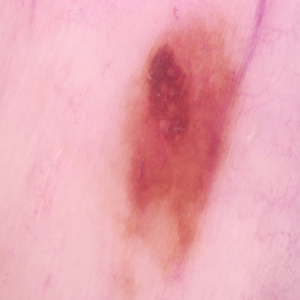

Label: nv


In [3]:
from torchvision.transforms import ToPILImage

loader.load_images(1) # Start with small fraction of the model to test set-up
X_images = loader.get_X()
y = loader.get_y()
num_classes = loader.get_num_classes()
#print(y)
# Check if images are being loaded correctly
print("X shape: " + str(X_images.shape))
print("y shape: " + str(y.shape))
print("Num classes: " + str(num_classes))
to_pil = ToPILImage()
image = to_pil(X_images[0])

# Now you can display or save the image
display(image.resize((300, 300)))
label_image = y[0].item()
print("Label: "+ loader.get_encoder().inverse_transform([label_image])[0])


### 1.3 Split into train and test set

In [4]:
X_images_train, X_images_test, y_train, y_test = loader.train_test_split_tensor()

### 1.4 Save pyTorch tensors and Encoders

Since the tensor dataset is too large to fit in the ram we can split it accordingly into smaller batches that will be later used during the training process

In [5]:
import torch
import pickle

def split_tensor_into_three(tensor, batch_count: int=3):
    split_size = len(tensor) // batch_count
    return torch.split(tensor, [split_size, split_size, len(tensor) - 2*split_size])

# Splitting both the image tensors and label tensors into three parts
X_images_train_parts = split_tensor_into_three(X_images_train)
y_train_parts = split_tensor_into_three(y_train)

# Saving the splits
for i, (X_part, y_part) in enumerate(zip(X_images_train_parts, y_train_parts), 1):
    torch.save(X_part, f'./tensors/train/X_images_train_part{i}.pt')
    torch.save(y_part, f'./tensors/train/y_train_part{i}.pt')

with open('media_managers/encoder.pkl', 'wb') as file:
    pickle.dump(loader.get_encoder(), file)

torch.save(X_images_test, './tensors/test/X_images_test.pt')
torch.save(y_test, './tensors/test/y_test.pt')

## 2. Data augmentation

### 2.0 Perform image augmentation, stack, and shuffle dataset

In [1]:
import torch
import gc
from src.DataAugmentation import Augmentation
from tqdm.auto import tqdm

for i in tqdm(range(1, 4), "Batch progressing"):
    X_images = torch.load(f'./tensors/train/X_images_train_part{i}.pt')
    y = torch.load(f'./tensors/train/y_train_part{i}.pt')
    
    augmenter = Augmentation(X_images, y)
    X_images_aug, y_aug = augmenter.perform_augmentation(augment_fraction=0.333)
    
    torch.save(X_images_aug, f'./tensors/train_aug/X_images_train_aug{i}.pt')
    torch.save(y_aug, f'./tensors/train_aug/y_train_aug{i}.pt')
    
    X_train_combined, y_train_combined = augmenter.stack_augmented_data()
    
    torch.save(X_train_combined, f'./tensors/train_combined/X_train_combined_part{i}.pt')
    torch.save(y_train_combined, f'./tensors/train_combined/y_train_combined_part{i}.pt')
    
     # Clear memory
    del X_images
    del y
    del X_images_aug
    del y_aug
    del X_train_combined
    del y_train_combined
    del augmenter
    gc.collect() 


Batch progressing:   0%|          | 0/3 [00:00<?, ?it/s]

Performing Data Augmentation:   0%|          | 0/889 [00:00<?, ?it/s]

Total size: 3559


Performing Data Augmentation:   0%|          | 0/889 [00:00<?, ?it/s]

Total size: 3559


Performing Data Augmentation:   0%|          | 0/889 [00:00<?, ?it/s]

Total size: 3561


## 3. CNN Model Training

### 3.0 Load tensors

In [ ]:
import pickle
import torch

with open('./media_managers/encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)
    
X_images = torch.load("./tensors/X_images_train.pt")
y = torch.load("./tensors/y_train.pt")
num_classes = len(loaded_encoder.classes_)
print("Num classes:" + str(num_classes))
print(X_images.shape)

### 3.1 Train with augmentation

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from src.Trainer import ModelTrainer
from src.CnnModel import SkinConditionClassifier

model = SkinConditionClassifier(num_classes) 

trainer = ModelTrainer(model, X_images, y, num_classes)

trainer.train_and_validate(epochs=40)




### 3.2 Save checkpoint

In [ ]:
import os

path = os.getcwd()
path += "/checkpoints/my_checkpoint.pth"
trainer.save_checkpoint(path)

### 3.3 Plot results

In [ ]:
import matplotlib.pyplot as plt

# Use the getter methods to obtain the data for plotting
train_losses = trainer.get_train_losses()
val_losses = trainer.get_val_losses()
train_accuracies = trainer.get_train_accuracies()
val_accuracies = trainer.get_val_accuracies()

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 3.4 Custom image test

In [ ]:
from PIL import Image
from src.Infer import InferenceEngine
import os

image_name = "ISIC_0031197"

inference_engine = InferenceEngine(model, device="cuda")
path = os.getcwd()
path = path+f'/skin_conditions_dataset/HAM10000_images/{image_name}.jpg'
image = Image.open(path)

display(image)
predictions = inference_engine.predict_probabilities(path)
print(predictions)

In [ ]:
import numpy as np
num_label = np.argmax(predictions)
print(predictions.flatten().shape)
label = loaded_encoder.inverse_transform([num_label])
print(label)

## 4. Model evaluation

### 4.0 Load model and data loader

In [ ]:
import pickle

with open('./media_managers/encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)
    

In [ ]:
import torch
import os

# Assuming `MyModel` is the class of your model
from src.CnnModel import SkinConditionClassifier

# Initialize model
model = SkinConditionClassifier(len(loaded_encoder.classes_))
# Load the checkpoint
checkpoint_path = os.path.join(os.getcwd(), "checkpoints/my_checkpoint.pth")
checkpoint = torch.load(checkpoint_path)

#print("Checkpoint's state_dict keys:")
#print(checkpoint['model_state_dict'].keys())

# Load the saved weights into the model
model.load_state_dict(checkpoint['model_state_dict'])
# Don't forget to move the model to the GPU if you are using one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
    

### 4.1 Evaluate model with full data set

In [ ]:
 # Initialize your DataLoader instance with the necessary parameters
from src.Infer import InferenceEngine
from src.Evaluate import ModelEvaluator

X_images = torch.load("./tensors/X_images_test.pt")
y = torch.load("./tensors/y_test.pt")

inference_engine = InferenceEngine(model, "cuda")
evaluator = ModelEvaluator(inference_engine, X_images, y, loaded_encoder)
y_true, y_pred = evaluator.evaluate(batch_size=32)

### 4.2 Output model metrics

Precision, recall, F1 score, and accuracy over the entire data set

In [ ]:
evaluator = ModelEvaluator(inference_engine, X_images, y, loaded_encoder)
precision, recall, f1, accuracy = evaluator.get_metrics(y_true, y_pred, zero_division=0)
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nAccuracy: {accuracy}")
# To print a full classification report:
evaluator.print_classification_report(y_true, y_pred)

### 4.3 Plot confusion matrix

In [ ]:
evaluator = ModelEvaluator(inference_engine, X_images, y, loaded_encoder)
class_names = loaded_encoder.classes_
print(class_names)
evaluator.plot_confusion_matrix(y_true, y_pred, class_names)
evaluator.plot_class_distribution(y_true, class_names)


## 4. Multimodal model design

So far we have built and train a model capable of only analyzing the visual part (images) of the medical report; nevertheless, for research purposes and further understanding of the HAM10000 data set; we proceed to consider the other information from the medical report --e.g., location of lesion-- which will maybe allow us to better classify the samples despite the heavy class imbalance. (We will deal with class imbalance in next section)